<a href="https://colab.research.google.com/github/jugalpanchal/bd-chef/blob/main/spark_etl_crime_anlys_recipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spark Session

In [1]:
# Follow the steps to install the dependencies:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # install java
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz # spark package download
!tar xf spark-3.1.2-bin-hadoop3.2.tgz # unzip spark package
!pip install -q findspark # install spark

# Set the location of Java and Spark:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

# create or get spark session
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("Spark_App1") \
        .getOrCreate()

sc = spark.sparkContext

### Read a file

In [3]:
data = spark.read\
            .format("csv")\
            .option("header", "true")\
            .load("datasets/london_crime_by_lsoa.csv")

data.count() #DataFrame count

5959790

In [4]:
# easy alternative
#data = spark.read.csv('datasets/london_crime_by_lsoa.csv', inferSchema=True, header=True)
data.printSchema()
data.show()
data.limit(5).show() # top 5

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)

+---------+--------------------+--------------------+--------------------+-----+----+-----+
|lsoa_code|             borough|      major_category|      minor_category|value|year|month|
+---------+--------------------+--------------------+--------------------+-----+----+-----+
|E01001116|             Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646|           Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|             Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774|           Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|          Wandsworth|             Robbery|   Personal Pro

### NA, Drop Column, Select, Distinct, Filter(==, isin, >=), Sample-Fraction 

In [5]:
data = data.dropna() # Drop NA values records(Rows)
data.count()

5959789

In [6]:
data.drop("lsoa_code")
total_borough = data.select("borough")\
    .distinct()

total_borough.show()

+--------------------+
|             borough|
+--------------------+
|             Croydon|
|          Wandsworth|
|              Bexley|
|             Lambeth|
|Barking and Dagenham|
|              Camden|
|           Greenwich|
|              Newham|
|       Tower Hamlets|
|            Hounslow|
|              Barnet|
|              Harrow|
|Kensington and Ch...|
|           Islington|
|               Brent|
|            Haringey|
|             Bromley|
|              Merton|
|         Westminster|
|             Hackney|
+--------------------+
only showing top 20 rows



In [7]:
hackney_data = data.filter(data['borough'] == 'Hackney')
hackney_data.show(5) # any 5

+---------+-------+--------------------+--------------------+-----+----+-----+
|lsoa_code|borough|      major_category|      minor_category|value|year|month|
+---------+-------+--------------------+--------------------+-----+----+-----+
|E01001786|Hackney|     Criminal Damage|Criminal Damage T...|    0|2011|    6|
|E01001794|Hackney|Violence Against ...|          Harassment|    1|2013|    2|
|E01001787|Hackney|     Criminal Damage|Other Criminal Da...|    0|2011|    7|
|E01001738|Hackney|Violence Against ...|        Wounding/GBH|    0|2013|   12|
|E01001807|Hackney|  Theft and Handling|  Other Theft Person|    0|2016|    8|
+---------+-------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [8]:
data_2015_2016 = data.filter(data['year'].isin(['2015', '2016'])) 
#data_2015_2016.count() # 2997912
data_2015_2016_fra_per = data_2015_2016.sample(fraction=0.000002) # Ex 0.2 means 20% so it creates a new dataframe with 20% data from source
data_2015_2016_fra_per.show()

+---------+-----------+------------------+--------------------+-----+----+-----+
|lsoa_code|    borough|    major_category|      minor_category|value|year|month|
+---------+-----------+------------------+--------------------+-----+----+-----+
|E01003631|     Newham|Theft and Handling|Theft/Taking of P...|    0|2015|    2|
|E01004727|Westminster|Theft and Handling|Theft/Taking of P...|    0|2015|    9|
+---------+-----------+------------------+--------------------+-----+----+-----+



In [9]:
data_data_onwards = data.filter(data['year'] >= 2016)
data_data_onwards.sample(fraction = 0.1).show() #10%

+---------+--------------------+--------------------+--------------------+-----+----+-----+
|lsoa_code|             borough|      major_category|      minor_category|value|year|month|
+---------+--------------------+--------------------+--------------------+-----+----+-----+
|E01002945|Kingston upon Thames|  Theft and Handling|    Theft From Shops|    0|2016|   11|
|E01004093|              Sutton|Violence Against ...|        Wounding/GBH|    0|2016|    7|
|E01004424|      Waltham Forest|Violence Against ...|      Other violence|    0|2016|    9|
|E01004314|       Tower Hamlets|             Robbery|   Personal Property|    0|2016|   10|
|E01000392|              Bexley|  Theft and Handling|  Other Theft Person|    0|2016|    8|
|E01002231|              Harrow|               Drugs| Possession Of Drugs|    0|2016|   11|
|E01002365|            Havering|Violence Against ...|          Harassment|    1|2016|    8|
|E01002367|            Havering|Other Notifiable ...|    Other Notifiable|    0|

### Aggregation - groupBy, agg, orderBy

In [10]:
borough_and_count = data.groupBy('borough')\
                        .count()

borough_and_count.show()

+--------------------+------+
|             borough| count|
+--------------------+------+
|             Croydon|265642|
|          Wandsworth|220599|
|              Bexley|169639|
|             Lambeth|229177|
|Barking and Dagenham|137662|
|              Camden|167783|
|           Greenwich|185912|
|              Newham|208229|
|       Tower Hamlets|181865|
|            Hounslow|174854|
|              Barnet|253624|
|              Harrow|162126|
|Kensington and Ch...|131679|
|           Islington|158855|
|               Brent|216902|
|            Haringey|182739|
|             Bromley|230906|
|              Merton|150365|
|         Westminster|161934|
|             Hackney|184319|
+--------------------+------+
only showing top 20 rows



In [11]:
# the sum is a method and the value is column in the dataframe.
#data = data.sample(fraction = 0.001)
borought_conviction_sum = data.groupBy('borough')\
                              .agg({"value":"sum"})\
                              .withColumnRenamed("sum(value)", "convictions")

borought_conviction_sum.show()

+--------------------+-----------+
|             borough|convictions|
+--------------------+-----------+
|             Croydon|   114282.0|
|          Wandsworth|    90357.0|
|              Bexley|    49998.0|
|             Lambeth|   128161.0|
|Barking and Dagenham|    66589.0|
|              Camden|   120238.0|
|           Greenwich|    80264.0|
|              Newham|   115143.0|
|       Tower Hamlets|   101035.0|
|            Hounslow|    82332.0|
|              Barnet|    93771.0|
|              Harrow|    51360.0|
|Kensington and Ch...|    76145.0|
|           Islington|   102326.0|
|               Brent|   100579.0|
|            Haringey|    94336.0|
|             Bromley|    81002.0|
|              Merton|    50903.0|
|         Westminster|   197658.0|
|             Hackney|    95427.0|
+--------------------+-----------+
only showing top 20 rows



In [12]:
borought_conviction_sum_total = borought_conviction_sum.agg({"convictions":"sum"})
borought_conviction_sum_total.show()
total_convictions = borought_conviction_sum_total.collect()[0][0] # 0 row and 0 column

+----------------+
|sum(convictions)|
+----------------+
|       2838575.0|
+----------------+



In [13]:
import pyspark.sql.functions as func
from pyspark.sql.functions import lit # literal

# Somehow it is not working.
borought_conviction_per = borought_conviction_sum.withColumn("contribution percentage(%)", 
                                                             func.round(borought_conviction_sum.convictions / total_convictions * 100, 2)\
                                                             )
borought_conviction_per.show(5)

+--------------------+-----------+--------------------------+
|             borough|convictions|contribution percentage(%)|
+--------------------+-----------+--------------------------+
|             Croydon|   114282.0|                      4.03|
|          Wandsworth|    90357.0|                      3.18|
|              Bexley|    49998.0|                      1.76|
|             Lambeth|   128161.0|                      4.51|
|Barking and Dagenham|    66589.0|                      2.35|
+--------------------+-----------+--------------------------+
only showing top 5 rows



In [14]:
# 2 column - contribution percentage(%)
borought_conviction_per.orderBy(borought_conviction_per[2].desc())\
                        .show()

+--------------+-----------+--------------------------+
|       borough|convictions|contribution percentage(%)|
+--------------+-----------+--------------------------+
|   Westminster|   197658.0|                      6.96|
|       Lambeth|   128161.0|                      4.51|
|     Southwark|   123643.0|                      4.36|
|        Camden|   120238.0|                      4.24|
|        Newham|   115143.0|                      4.06|
|       Croydon|   114282.0|                      4.03|
|        Ealing|   111321.0|                      3.92|
|     Islington|   102326.0|                       3.6|
| Tower Hamlets|   101035.0|                      3.56|
|         Brent|   100579.0|                      3.54|
|       Hackney|    95427.0|                      3.36|
|      Lewisham|    94720.0|                      3.34|
|      Haringey|    94336.0|                      3.32|
|        Barnet|    93771.0|                       3.3|
|    Hillingdon|    92173.0|                    

In [15]:
conviction_monthly = data.filter(data['year'] == 2014)\
                          .groupBy('month')\
                          .agg({"value":"sum"})\
                          .withColumnRenamed("sum(value)", "convictions")

conviction_monthly.show()

+-----+-----------+
|month|convictions|
+-----+-----------+
|    7|    25922.0|
|   11|    26119.0|
|    3|    25648.0|
|    8|    24868.0|
|    5|    24471.0|
|    6|    25211.0|
|    9|    24762.0|
|    1|    24456.0|
|   10|    26536.0|
|    4|    23494.0|
|   12|    25529.0|
|    2|    22376.0|
+-----+-----------+



### Convert the column values to column names

In [16]:
# Two columns - 1st, 2nd
# New column - value from 1st column, Values from 2nd column, ...
data.crosstab('borough', 'major_category')\
    .select('borough_major_category', 'Burglary', 'Drugs', 'Fraud or Forgery', 'Robbery')\
    .show()

+----------------------+--------+-----+----------------+-------+
|borough_major_category|Burglary|Drugs|Fraud or Forgery|Robbery|
+----------------------+--------+-----+----------------+-------+
|              Havering|   14332|14499|            2406|  12227|
|                Merton|   11836|13059|            2547|  10443|
|              Haringey|   13736|15672|            4598|  13021|
|         Tower Hamlets|   13751|16679|            2364|  12530|
|               Bromley|   18705|18685|            3749|  15425|
|               Enfield|   17562|19369|            4328|  15581|
|  Kingston upon Thames|    9267| 9788|            1711|   6877|
|           Westminster|   12134|14298|            3855|  11050|
|  Richmond upon Thames|   10946|10182|            1264|   8128|
|              Lewisham|   16148|19212|            4868|  15468|
|                 Brent|   16410|20789|            4036|  15138|
|  Barking and Dagenham|   10498|11613|            3257|   9702|
|             Redbridge| 

### Plot - MatPlotLib

> Indented block



In [17]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [18]:
def describe_year(year):
    yearly_details = data.filter(data.year == year)\
                         .groupBy('borough')\
                         .agg({'value':'sum'})\
                         .withColumnRenamed("sum(value)","convictions")
    
    borough_list = [x[0] for x in yearly_details.toLocalIterator()]
    convictions_list = [x[1] for x in yearly_details.toLocalIterator()]
  
    plt.figure(figsize=(33, 10)) 
    plt.bar(borough_list, convictions_list)
    
    plt.title('Crime for the year: ' + year, fontsize=30)
    plt.xlabel('Boroughs',fontsize=30)
    plt.ylabel('Convictions', fontsize=30)

    plt.xticks(rotation=90, fontsize=30)
    plt.yticks(fontsize=30)
    plt.autoscale()
    plt.show()

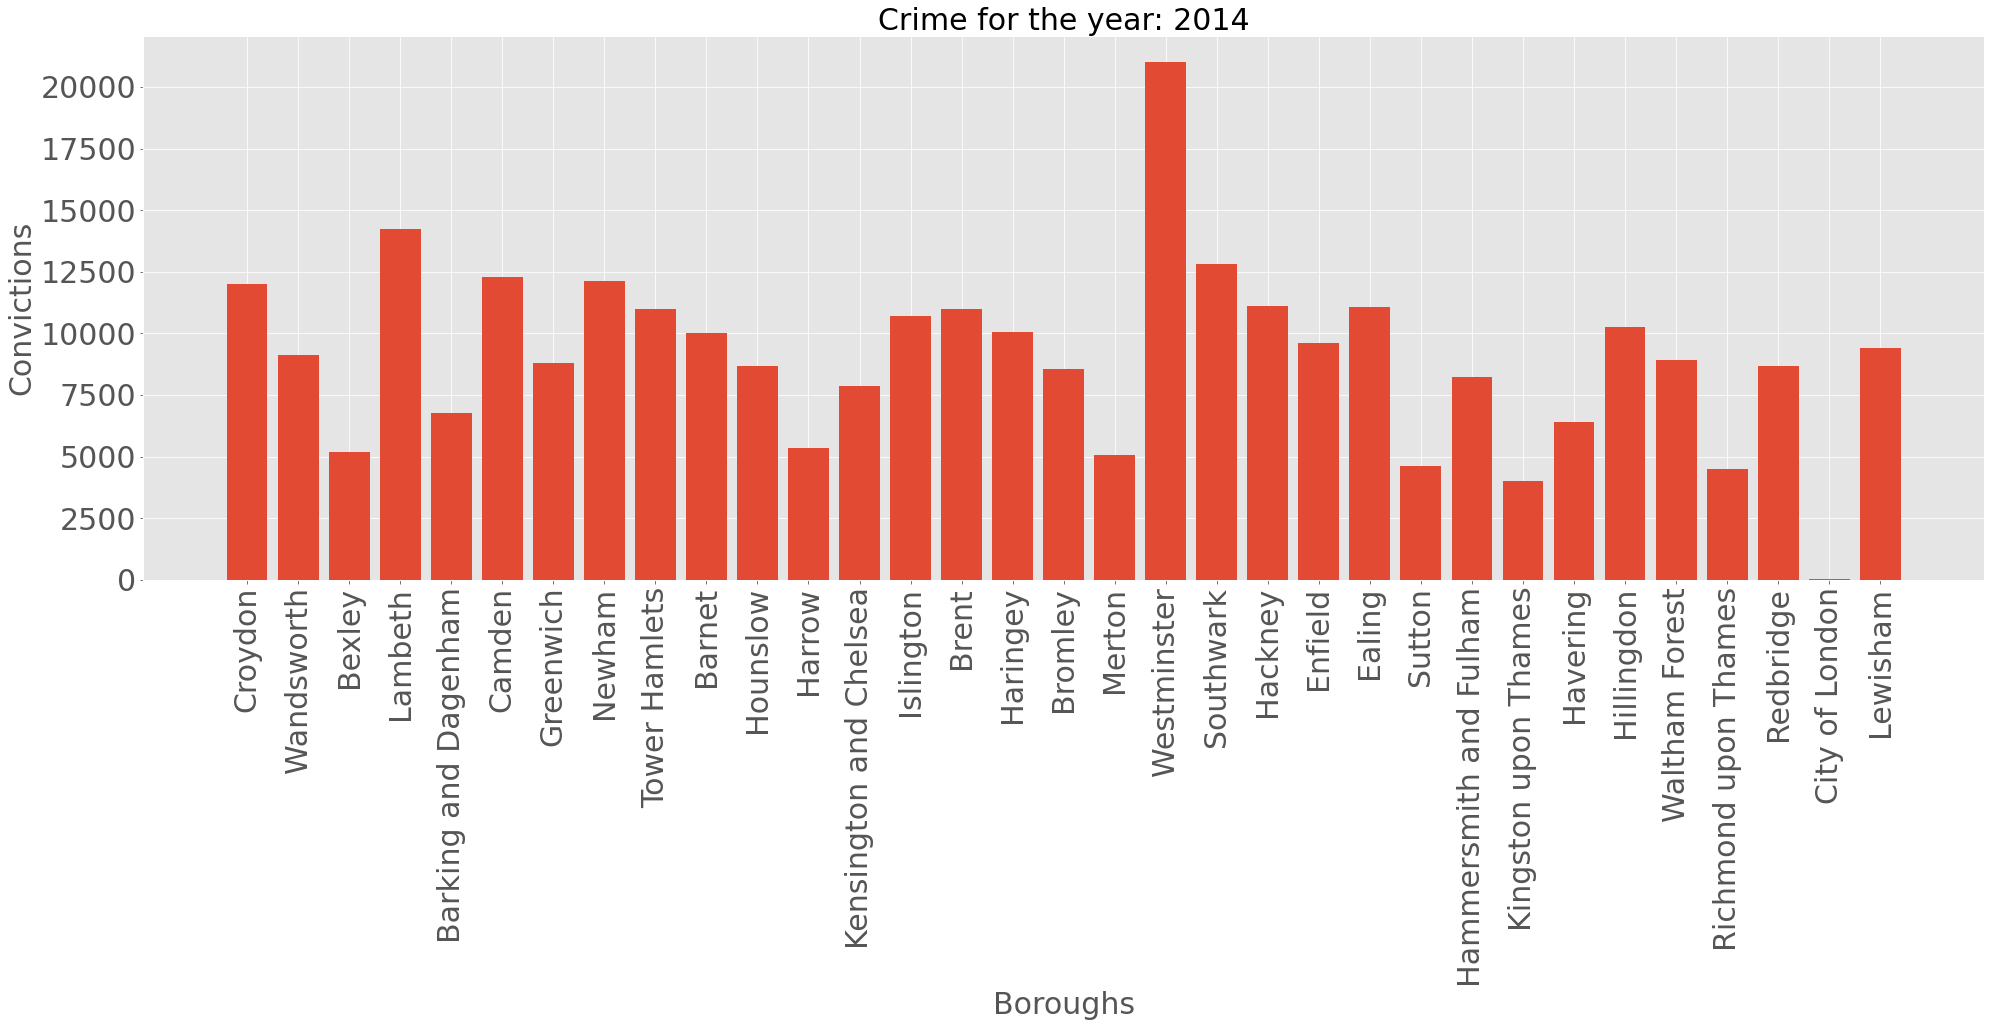

In [19]:
describe_year('2014')